In [ ]:
import base_defs as base
from importlib import reload; reload(base)
import zipfile
import time
import MDAnalysis as mda
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shutup
from io import BytesIO
from io import StringIO
import gzip as gz
import warnings
import os
import re
import random
import pickle

zip_path_virus = "/media/andrej/KEYCHAIN II/bsr_data/ProBiS_Dock_DB_bs_id1division_id9.zip"
#zip_path_virus = "E:/bsr_data/ProBiS_Dock_DB_bs_id1division_id9.zip"

### Validating rasa cutoff optimization

If the natural tendency of hydrophobic amino acids is to curl towards the interior of the protein, and the opposite holds for hydrophilic AAs, tending to be exposed to the solvent, would the optimal RASA cutoff for defining the surface be one where the number of "misplaced" residues is minimal (ie hydrophobic ones on the exterior + hydrophilic ones on the interior)?

Steps:

Load protein, compute RASA dictionary

Save all aminoacids in table of format:

    is_hydrophobic | RASA
    True           | 0.23

Build array of counts with different cutoffs (can do other optimizations later).


In [ ]:
# I will not be counting neutral AAs, categorization is as given in https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/IMGTclasses.html

aa_dict = {}
hydrophobic_aas =  ["ALA", "CYS", "ILE", "LEU", "MET", "PHE", "TRP", "VAL"]
hydrophilic_aas = ["ASN", "ASP", "GLN", "GLU", "LYS", "ARG"]
neutral_aas = ["GLY","THR","SER","TYR","PRO","HIS"]

for phob_aa in hydrophobic_aas:
    aa_dict[phob_aa] = "phobic"
for phil_aa in hydrophilic_aas:
    aa_dict[phil_aa] = "philic"
# for nt_aa in neutral_aas:
#     aa_dict[nt_aa] = "neutral"

In [ ]:
def get_rasa_table(filegroup, aa_dict, probis_zip):
    def try_dict(rasa_dict, x):
        try:
            if rasa_dict[x]!="NA":
                return rasa_dict[x]
        except:
            return None

    loaded_files = []
    for fname in filegroup:
        gzippeddata = BytesIO(probis_zip.read(fname))
        with gz.GzipFile(fileobj=gzippeddata) as gzfile:
            loaded_files.append(gzfile.read().decode())
    
    rdkit_rec = base.merge_pdb_to_mol(loaded_files[0])
    mda_rec = mda.Universe(rdkit_rec)
    rasa_dict = base.get_rasa_dict(rdkit_rec)
    
    #return pd.DataFrame([[x.resnum, x.resname, aa_dict[x.resname]=="phobic", try_dict(rasa_dict, x.resnum)] for x in mda_rec.residues], columns = ["resnum", "name", "phobic", "rasa"])#.set_index(["resnum"])
    return [[try_dict(aa_dict,x.resname)=="phobic", try_dict(rasa_dict, x.resnum)] for x in mda_rec.residues if try_dict(aa_dict,x.resname)!= None]

with zipfile.ZipFile(zip_path_virus, 'r') as probis_zip:
    shutup.please()
    pdb_dict = base.get_file_name_dict(probis_zip)
    master_list = []
    for i, elt in enumerate(pdb_dict):
        print(elt)
        temp_list=[]
        for filegroup in pdb_dict[elt]:
            temp_list+=get_rasa_table(filegroup, aa_dict, probis_zip)
        master_list.append(temp_list)
        if i == 99: break
    shutup.jk()


2nnk
3pu0
1ar6
2gol
5m0r
3irx
3vkw
6o9e
4tn2
2r3t
2im2
1fg8
6e3m
3kfn
6h72
2qhc
3el4
6jpw
3vie
4k4w
4cpu
4k4q
6pjb
1idb
6nsa
2jlq
1vps
6u7k
5uty
3tic
5b18
1hgh
3hmg
2r2r
1ajv
3ffi
3d0i
2gon
4kps
6v8x
5hu8
5i27
1ruc
6noz
4cqv
6d8d
3qlh
1m9d
4l1a
6tik
5ls4
6ce0
6ohy
4cyw
3vqe
2jh8
6hfy
2p3c
4d00
4u0b
6o3v
7c4z
1ex4
6mph
6u0n
5f4p
6wkq
4cdq
3jd7
3em3
3psu
5kuy
4hvp
2yp9
5kr0
3m3s
4mbz
4bh1
6uye
3med
5jw4
5uk2
6h6m
2qi4
1mrx
6bsh
6akt
3ng9
6w01
6n5e
4ln6
2jls
1bqn
5tsk
6nf2
5y9f
6fs7
3nl0
6pjl
3kxs


In [ ]:
master_list_path = "./data/rasa_master_list.pkl"
if not os.path.isfile(master_list_path):
    pickle.dump(master_list, open(master_list_path, 'wb'))
else:
    master_list = pickle.load(open(master_list_path, 'rb'))

In [ ]:
def build_counts(rasa_lists, resolution):
    per_prot=[]
    for rasa_list in rasa_lists:
        counts = []
        for x in range(0, resolution):
            cutoff = x/resolution
            n_aas_surf_phobic = 0
            n_aas_surf_philic = 0
            n_aas_core_philic = 0
            n_aas_core_phobic = 0
            for is_phobic, rasa in rasa_list:
                if rasa is not None:
                    if rasa>=cutoff: # if residue is exposed
                        if is_phobic:
                            n_aas_surf_phobic+=1
                        else:
                            n_aas_surf_philic+=1
                    else:           # if residue is in core
                        if is_phobic:
                            n_aas_core_phobic+=1
                        else:
                            n_aas_core_philic+=1
            
            counts.append([cutoff, n_aas_surf_phobic, n_aas_core_philic, n_aas_surf_phobic+n_aas_surf_philic+n_aas_core_philic+n_aas_core_phobic])
        per_prot.append(counts)
    
    return per_prot

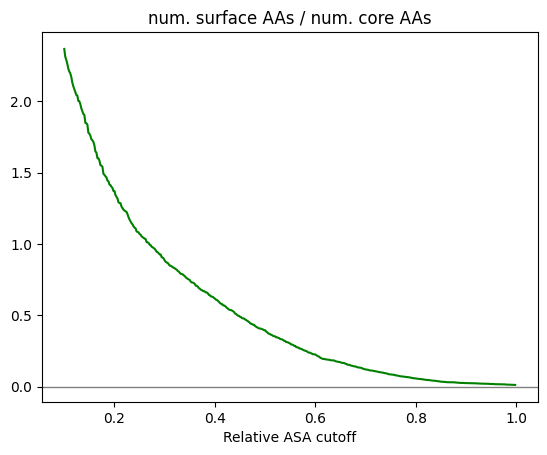

In [ ]:
# res = 500
# counts = build_counts(master_list, res)

# x = [x/res for x in range(0, res)][int(res/10):] # knock out the first tenth of the plot as it falls rapidly, ruining the plot, but represents bad cutoff values anyways.
# y_surf = [x[1] for x in counts][int(res/10):]

# y_core = [x[2] for x in counts][int(res/10):]
# y_ratio = [x[3] for x in counts][int(res/10):]


# #plt.plot(x, y_surf, c="blue")
# #plt.plot(x, y_core, c="orange")
# plt.plot(x, y_ratio, c="green")
# plt.title("num. surface AAs / num. core AAs")
# plt.xlabel("Relative ASA cutoff")
# plt.axhline(y=0, color="black", alpha=0.5, linewidth=1)
# plt.show()

In [ ]:
res = 500
counts = build_counts(master_list, res)

x = [x/res for x in range(0, res)] 

surface_quality = [[(x[1]+x[2])/x[3] for x in elt] for elt in counts]


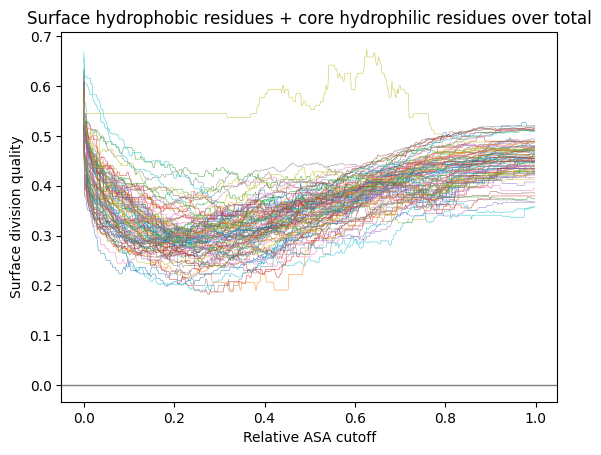

In [ ]:
fig = plt.figure()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()
#y_core = [x[2] for x in counts][int(res/100):]
#y_ratio = [x[3] for x in counts][int(res/100):]
for i, single_protein_quality in enumerate(surface_quality):
    plt.plot(x, single_protein_quality,linewidth=0.4, alpha=0.8)
#plt.plot(x, y_core_philic, c="orange")
#plt.plot(x, y_core, c="orange")
#plt.plot(x, y_ratio, c="green")
plt.title("Surface hydrophobic residues + core hydrophilic residues over total")
plt.xlabel("Relative ASA cutoff")
plt.ylabel("Surface division quality")

plt.axhline(y=0, color="black", alpha=0.5, linewidth=1)
plt.show()

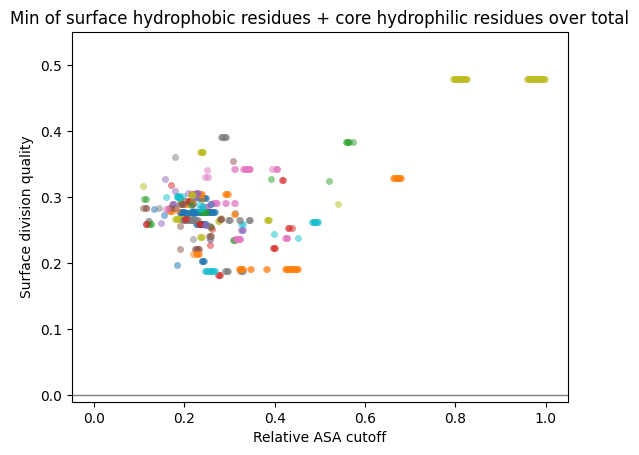

In [ ]:
fig = plt.figure()
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()
#y_core = [x[2] for x in counts][int(res/100):]
#y_ratio = [x[3] for x in counts][int(res/100):]
for i, single_protein_quality in enumerate(surface_quality):
    plt.scatter(x, [x if x == min(single_protein_quality) else -100 for x in single_protein_quality ],linewidth=0.4, alpha=0.5, s = 20)
plt.ylim(-0.01, 0.55)
#plt.plot(x, y_core_philic, c="orange")
#plt.plot(x, y_core, c="orange")
#plt.plot(x, y_ratio, c="green")
plt.title("Min of surface hydrophobic residues + core hydrophilic residues over total")
plt.xlabel("Relative ASA cutoff")
plt.ylabel("Surface division quality")

plt.axhline(y=0, color="black", alpha=0.5, linewidth=1)
plt.show()

In [ ]:
from rdkit import Chem

In [ ]:
def get_rasa_table_from_pdb(pdbpath, aa_dict):
    def try_dict(rasa_dict, x):
        try:
            if rasa_dict[x]!="NA":
                return rasa_dict[x]
        except:
            return None
    
    rdkit_rec = Chem.MolFromPDBFile(pdbpath, sanitize=False, removeHs=False, proximityBonding=False)
    mda_rec = mda.Universe(rdkit_rec)
    rasa_dict = base.get_rasa_dict(rdkit_rec)
    
    #return pd.DataFrame([[x.resnum, x.resname, aa_dict[x.resname]=="phobic", try_dict(rasa_dict, x.resnum)] for x in mda_rec.residues], columns = ["resnum", "name", "phobic", "rasa"])#.set_index(["resnum"])
    return [[try_dict(aa_dict,x.resname)=="phobic", try_dict(rasa_dict, x.resnum)] for x in mda_rec.residues if try_dict(aa_dict,x.resname)!= None]


In [ ]:
nonsols_files = os.listdir("./data/sols_nonsols data/nonsols")
sols_files = os.listdir("./data/sols_nonsols data/sols")


In [ ]:
def build_master_list(path):
    files = os.listdir(path)
    master_list=[]
    for i, elt in enumerate(files):
        print("\r"+elt+" "+str(i), end = "")
        master_list.append(get_rasa_table_from_pdb(path+elt, aa_dict))
    return master_list

In [ ]:
shutup.please()
nonsols_master_list = build_master_list("./data/sols_nonsols data/nonsols/")
print("Second step:")
sols_master_list = build_master_list("./data/sols_nonsols data/sols/")
shutup.jk()

1vyhE00.pdb 246Second step:
1wdyA00.pdb 104

nonsols


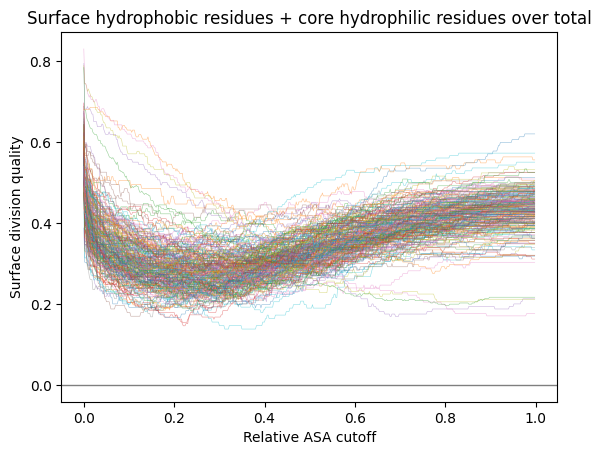

0.2331288343558282


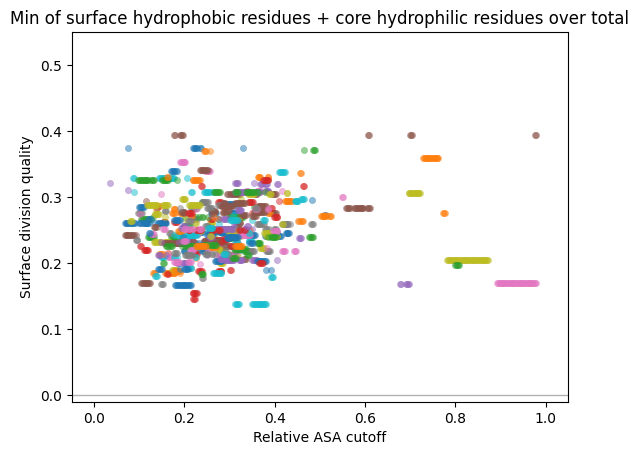

sols


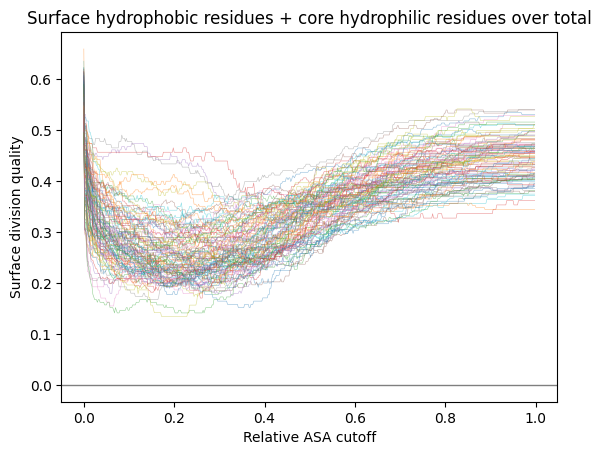

0.17543859649122806


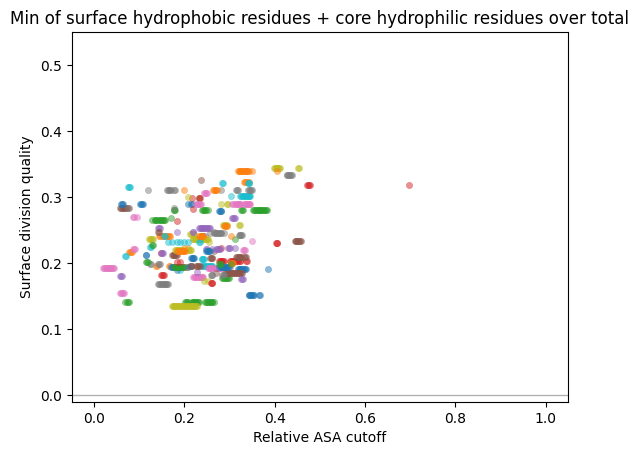

In [ ]:

from numpy import mean


def plot_surf_quality(master_list):
    res = 500
    counts = build_counts(master_list, res)
    x = [x/res for x in range(0, res)] 
    surface_quality = [[(x[1]+x[2])/x[3] for x in elt] for elt in counts]
    fig = plt.figure()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    for i, single_protein_quality in enumerate(surface_quality):
        plt.plot(x, single_protein_quality,linewidth=0.4, alpha=0.5)
    plt.title("Surface hydrophobic residues + core hydrophilic residues over total")
    plt.xlabel("Relative ASA cutoff")
    plt.ylabel("Surface division quality")

    plt.axhline(y=0, color="black", alpha=0.5, linewidth=1)
    plt.show()

def plot_surf_best(master_list):
    res = 500
    counts = build_counts(master_list, res)
    x = [x/res for x in range(0, res)] 
    surface_quality = [[(x[1]+x[2])/x[3] for x in elt] for elt in counts]
    fig = plt.figure()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    #y_core = [x[2] for x in counts][int(res/100):]
    #y_ratio = [x[3] for x in counts][int(res/100):]
    for i, single_protein_quality in enumerate(surface_quality):
        plt.scatter(x, [x if x == min(single_protein_quality) else -100 for x in single_protein_quality ],linewidth=0.4, alpha=0.5, s = 20)
    print(mean([x for x in single_protein_quality if x == min(single_protein_quality) ]))
    plt.ylim(-0.01, 0.55)
    #plt.plot(x, y_core_philic, c="orange")
    #plt.plot(x, y_core, c="orange")
    #plt.plot(x, y_ratio, c="green")
    plt.title("Min of surface hydrophobic residues + core hydrophilic residues over total")
    plt.xlabel("Relative ASA cutoff")
    plt.ylabel("Surface division quality")

    plt.axhline(y=0, color="black", alpha=0.3, linewidth=1)
    plt.show()
print("nonsols")
plot_surf_quality(nonsols_master_list)
plot_surf_best(nonsols_master_list)
print("sols")
plot_surf_quality(sols_master_list)
plot_surf_best(sols_master_list)
